# Probabilistic Roadmap


In this notebook you'll expand on previous random sampling exercises by creating a graph from the points and running A*.

1. Load the obstacle map data
2. Sample nodes (use KDTrees here)
3. Connect nodes (use KDTrees here)
4. Visualize graph
5. Define heuristic
6. Define search method
7. Execute and visualize

We'll load the data for you and provide a template for visualization.

In [1]:
# Again, ugly but we need the latest version of networkx!
# This sometimes fails for unknown reasons, please just 
# "reset and clear output" from the "Kernel" menu above 
# and try again!
import sys
!{sys.executable} -m pip install -I networkx==2.1
import pkg_resources
pkg_resources.require("networkx==2.1")
import networkx as nx

  Using cached decorator-4.2.1-py2.py3-none-any.whl
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
nx.__version__ # should be 2.1

'2.1'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point, LineString
from queue import PriorityQueue
from sklearn.neighbors import KDTree

%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = 14, 14

## Step 1 - Load Data

In [5]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ..., 
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


## Step 2 - Sample Points


You may want to limit the z-axis values.

In [6]:
def extract_polygons_and_centers(data):

    polygons = []
    centers = []
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]
        
        # TODO: Extract the 4 corners of the obstacle
        # 
        obstacle = [north - d_north, north + d_north, east - d_east, east + d_east]
        # NOTE: The order of the points matters since
        # `shapely` draws the sequentially from point to point.
        #
        # If the area of the polygon is 0 you've likely got a weird
        # order.
        corners = [(obstacle[0], obstacle[2]), (obstacle[0], obstacle[3]), (obstacle[1], obstacle[3]), (obstacle[1], obstacle[2])]
        
        # TODO: Compute the height of the polygon
        height = alt + d_alt

        # TODO: Once you've defined corners, define polygons
        #p = Polygon(corners)
        #polygons.append((p, height))
        poly = Polygon(corners)
        polygons.append((poly, height))

        c = [north, east]
        centers.append(c)
    return polygons, np.asarray(centers)

In [7]:
def collides(polygons, tree, point):   
    # TODO: Determine whether the point collides
    # with any obstacles.
    collide = False
    x,y,z = point
    p = Point(x, y)
    
    #find the nearest polygon center
    p_array = np.array([x,y])
    idx = tree.query([p_array], k=1, return_distance = False)[0]
    
    poly = polygons[int(idx)]
    polygon, height = poly
    if polygon.contains(p):
        if z < height:
            collide = True
            
    return collide

In [17]:

# TODO: sample points randomly

xmin = np.min(data[:, 0] - data[:, 3])
xmax = np.max(data[:, 0] + data[:, 3])

ymin = np.min(data[:, 1] - data[:, 4])
ymax = np.max(data[:, 1] + data[:, 4])

zmin = 0
# Limit the z axis for the visualization
zmax = 10

print("X")
print("min = {0}, max = {1}\n".format(xmin, xmax))

print("Y")
print("min = {0}, max = {1}\n".format(ymin, ymax))

print("Z")
print("min = {0}, max = {1}".format(zmin, zmax))

num_samples = 1000

xvals = np.random.uniform(xmin, xmax, num_samples)
yvals = np.random.uniform(ymin, ymax, num_samples)
zvals = np.random.uniform(zmin, zmax, num_samples)

samples = list(zip(xvals, yvals, zvals))

samples[:10]

#np.random.seed(0)
#points = np.random.random((10, 3))
#print(points)

# Create the centers of the polygons
polygons, centers = extract_polygons_and_centers(data)
print(centers[:10])



X
min = -315.2389, max = 604.7611

Y
min = -444.2315, max = 475.7685

Z
min = 0, max = 10
[[-310.2389 -439.2315]
 [-300.2389 -439.2315]
 [-290.2389 -439.2315]
 [-280.2389 -439.2315]
 [-220.2389 -439.2315]
 [-210.2389 -439.2315]
 [-170.2389 -439.2315]
 [-160.2389 -439.2315]
 [-150.2389 -439.2315]
 [-140.2389 -439.2315]]


In [18]:
# then use KDTree to find nearest neighbor polygon
# and test for collision
tree = KDTree(centers)

In [19]:
import time

t0 = time.time()
to_keep = []
for point in samples:
    if not collides(polygons, tree, point):
        to_keep.append(point)
time_taken = time.time() - t0
print("Time taken {0} seconds ...", time_taken)

Time taken {0} seconds ... 0.14477801322937012


In [20]:
print(len(to_keep))

666


## Step 3 - Connect Nodes

Now we have to connect the nodes. There are many ways they might be done, it's completely up to you. The only restriction being no edge connecting two nodes may pass through an obstacle.

NOTE: You can use `LineString()` from the `shapely` library to create a line. Additionally, `shapely` geometry objects have a method `.crosses` which return `True` if the geometries cross paths, for instance your `LineString()` with an obstacle `Polygon()`!

In [21]:
# TODO: connect nodes
# Suggested method
    # 1) cast nodes into a graph called "g" using networkx
    # 2) write a method "can_connect()" that:
        # casts two points as a shapely LineString() object
        # tests for collision with a shapely Polygon() object
        # returns True if connection is possible, False otherwise
    # 3) write a method "create_graph()" that:
        # defines a networkx graph as g = Graph()
        # defines a tree = KDTree(nodes)
        # test for connectivity between each node and 
            # k of it's nearest neighbors
        # if nodes are connectable, add an edge to graph
    # Iterate through all candidate nodes!

In [22]:
def can_connect(p1, p2, obstacles):
    x1,y1,z1 = p1
    x2,y2,z2 = p2
    
    line = LineString([(x1, y1), (x2, y2)])
    free = True
    
    for obst in obstacles:
        poly, height = obst
        if line.crosses(poly):
            free = False
    
    return free

In [26]:
def create_graph(milestones, polygons, k):
    array_milestones = np.array(milestones)
    #print(array_milestones[:10])
    m_tree = KDTree(array_milestones)
    g = nx.Graph()
    
    for mil in milestones:
        #print(mil)
        
        mil_array = np.array(mil)
        #print(mil_array)
        # find the nearest k milestones
        distances, indexes = m_tree.query([mil_array], k)

        #print(dist)
        #print(idx)
        for dist, idx in zip(distances[0], indexes[0]):
            #print(dist)
            #print(idx)
            if dist > 0:
                if can_connect(mil, milestones[int(idx)], polygons):
                    g.add_edge(mil, milestones[int(idx)], weight=dist)
        
    return g

In [45]:
# TODO: create the graph
k = 6
g = create_graph(to_keep, polygons, k)

## Step 4 - Visualize Graph

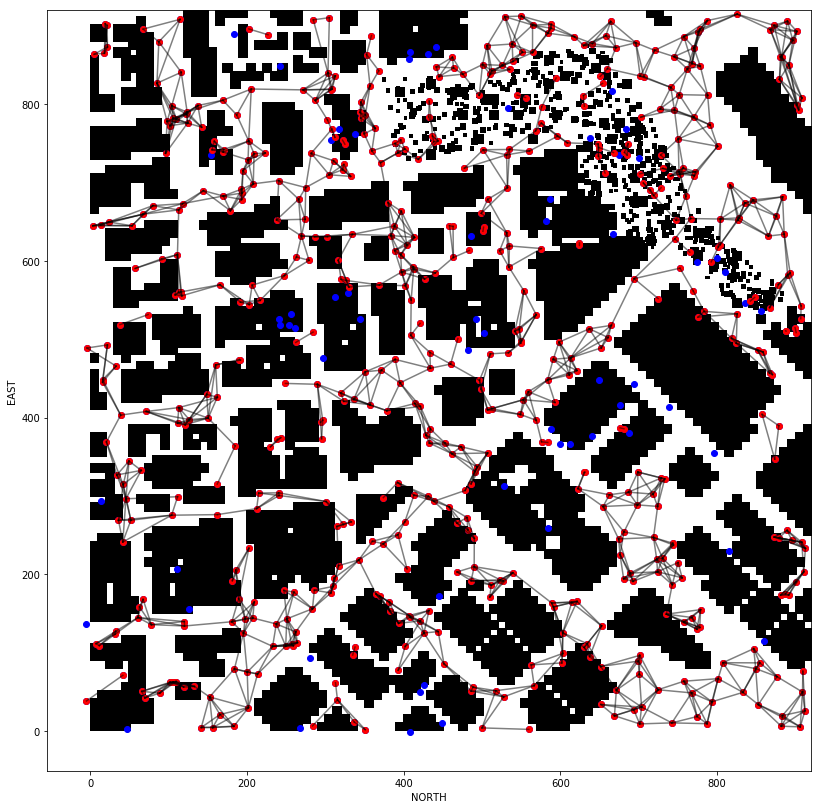

In [46]:
# Create a grid map of the world
from grid import create_grid
# This will create a grid map at 1 m above ground level
grid = create_grid(data, 1, 1)

fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])

# If you have a graph called "g" these plots should work
# Draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)

# Draw all nodes connected or not in blue
for n1 in to_keep:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='blue')
    
# Draw connected nodes in red
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

## Step 5 - Define Heuristic

In [47]:
import numpy.linalg as LA

def heuristic(n1, n2):
    # TODO: finish
    return LA.norm(np.array(n2) - np.array(n1))

## Step 6 - Complete A*

In [48]:
def a_star(graph, heuristic, start, goal):
    """Modified A* to work with NetworkX graphs."""
    
    # TODO: complete

    path = []
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_cost = item[0]
        current_node = item[1]

        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for next_node in graph[current_node]:
                cost = graph.edges[current_node, next_node]['weight']
                new_cost = current_cost + cost + heuristic(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    queue.put((new_cost, next_node))
                    
                    branch[next_node] = (new_cost, current_node)
             
    path = []
    path_cost = 0
    if found:
        
        # retrace steps
        path = []
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
            
    return path[::-1], path_cost


In [49]:
start = list(g.nodes)[0]
k = np.random.randint(len(g.nodes))
print(k, len(g.nodes))
goal = list(g.nodes)[k]
print('start', start)
print('goal', goal)

path, cost = a_star(g, heuristic, start, goal)
print(len(path), path)

path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    print(n1, n2)

321 603
start (178.51550717028101, -443.52705558026742, 1.0019532908941853)
goal (5.0714982659957855, 46.79992283614888, 2.0946680416984109)
Found a path.
22 [(178.51550717028101, -443.52705558026742, 1.0019532908941853), (155.40083659392093, -406.31123499571407, 6.8546677876871769), (138.28481825687084, -423.41220293069352, 8.061826621085066), (92.844136658415323, -400.49906845212178, 0.88089442811709717), (58.620184886040988, -418.71136128124567, 0.77957993996710107), (4.3030160760238232, -397.29209799110322, 1.3827729325435756), (-41.355525494520236, -387.48764093629836, 3.3325433583164776), (-34.899551653158483, -335.47915647859634, 9.8535188373313396), (-34.142573489091887, -276.96027759490426, 5.3538303384970973), (-26.45225021491035, -226.90283481061789, 6.8634952296391987), (-9.7473696151429863, -198.28643444296372, 1.012163106321543), (-17.480030052765585, -138.25890835125415, 7.4727906907151311), (-43.419428597772253, -106.10945255933274, 4.2782528360734133), (-49.25259351469

## Step 7 - Visualize Path

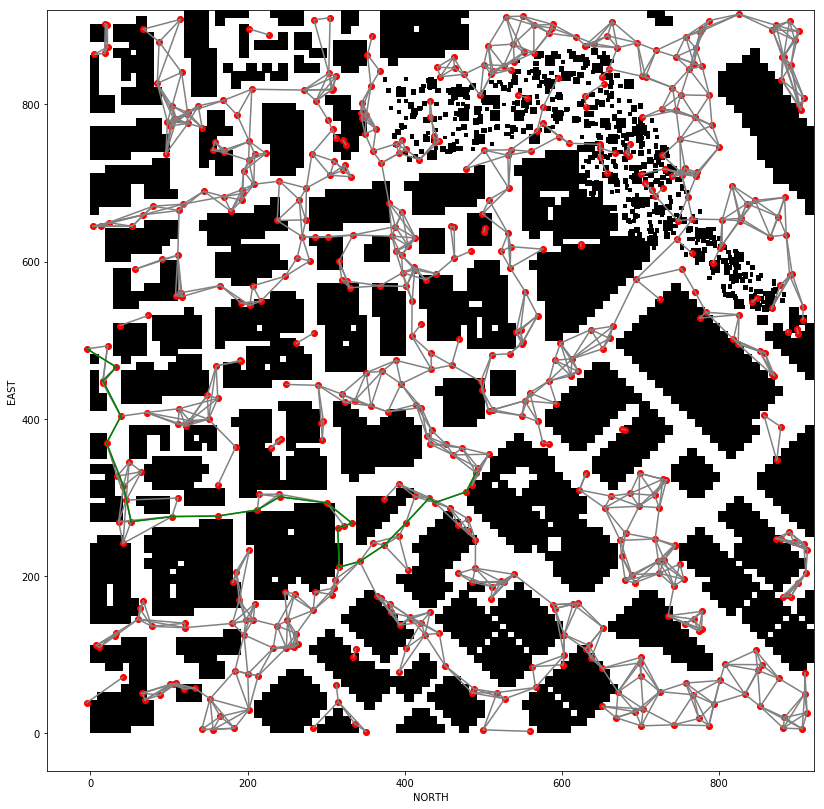

In [52]:
fig = plt.figure()

plt.imshow(grid, cmap='Greys', origin='lower')

nmin = np.min(data[:, 0])
emin = np.min(data[:, 1])
   
# draw nodes
for n1 in g.nodes:
    plt.scatter(n1[1] - emin, n1[0] - nmin, c='red')
    
# draw edges
for (n1, n2) in g.edges:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'grey')
    
# TODO: add code to visualize the path
path_pairs = zip(path[:-1], path[1:])
for (n1, n2) in path_pairs:
    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'green')
    


plt.xlabel('NORTH')
plt.ylabel('EAST')

plt.show()

[solution](/notebooks/Probabilistic-Roadmap-Solution.ipynb)